In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

## H14.1: Inverted Pendulum

#### a) Write a function that simulates one time step of the pole’s dynamics

In [2]:
class Environment():    
    
    dt = 0.02
    g = 9.81
    l = 1
    m = 2
    actions = {'NO_FORCE': 0, 'LEFT': 1, 'RIGHT': 2}
    
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.angle = 0
        self.angular_velocity = 0
        self.num_steps = 0
        return (self.angle, self.angular_velocity)
        
    def step(self, action):
        epsilon = np.random.normal(scale=3)
        if action == self.actions['NO_FORCE']:
            force = 0
        elif action == self.actions['LEFT']:
            force = -4
        elif action == self.actions['RIGHT']:
            force = 4
        self.angular_velocity += self.g / self.l * np.sin(self.angle) * self.dt + force / self.m * self.dt + epsilon / self.m * self.dt
        self.angle += self.angular_velocity * self.dt
        self.num_steps += 1
        
        if np.abs(self.angle) > np.pi / 4:
            reward = -1
            finished = True
        elif self.num_steps >= 1000:
            reward = 0
            finished = True
        else:
            reward = 0
            finished = False            
        
        return (self.angle, self.angular_velocity), reward, finished, {'step': self.num_steps, 'time': self.dt * self.num_steps}
        

In [3]:
env = Environment()

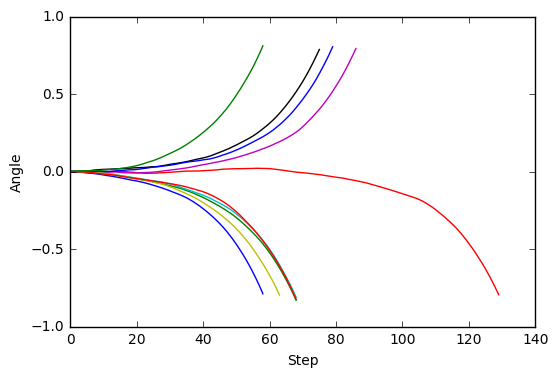

In [4]:
for i in range(10):
    angles = []
    env.reset()
    finished = False
    while not finished:
        (angle, angular_velocity), reward, finished, info = env.step(env.actions['NO_FORCE'])
        angles.append(angle)        
    plt.plot(angles)
    
plt.xlabel('Step')
plt.ylabel('Angle')

#### b) Write a function that assigns a discrete state

In [5]:
def state_to_index(state, D1=50, D2=50):
    angle, angular_velocity = state
    d1 = int(np.interp(angle, [-np.pi/4, np.pi/4], [0, D1-1]))
    d2 = int(np.interp(angular_velocity, [-3, 3], [0, D2-1]))
    return d1 + d2 * D1

state_to_index((-np.pi/4, -3)), state_to_index((0, 0)), state_to_index((np.pi/4, 3))

(0, 1224, 2499)

In [6]:
states = np.random.multivariate_normal([0, 0], [[(np.pi/8)**2, 0], [0, (3/2)**2]], 100000)

In [7]:
state_indices = map(state_to_index, states)
counts = np.zeros(50*50)
for i in state_indices:
    counts[i] += 1

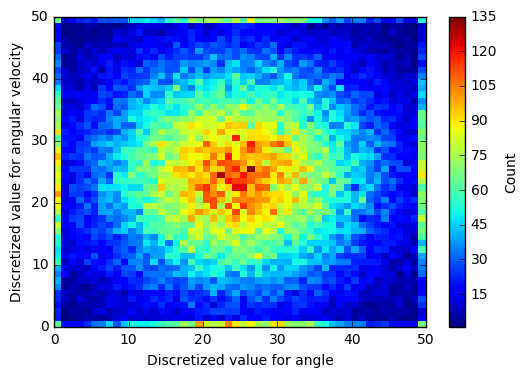

In [8]:
plt.pcolor(counts.reshape(50, 50))
plt.xlabel('Discretized value for angle')
plt.ylabel('Discretized value for angular velocity')
plt.colorbar(label='Count')

## H14.2: Q-learning

#### a) Implement Q-learning

In [9]:
epsilon = 0
eta = 0.5
gamma = 0.9

In [19]:
env = Environment()
Q = np.zeros((50 * 50, 3))
steps_per_episode = []

for episode in range(2000):
    
    state = env.reset()
    finished = False

    while not finished:
        if np.random.rand() <= epsilon:
            action = np.random.randint(3)
        else:
            action = np.argmax(Q[state_to_index(state)])

        new_state, reward, finished, info = env.step(action)
        Q[state_to_index(state), action] += eta * (reward + gamma * np.max(Q[state_to_index(new_state)] - Q[state_to_index(state), action]))
        state = new_state

        if finished:
#             print 'Finished episode {} after {} time steps with reward {}'.format(episode, info['step'], reward)
            steps_per_episode.append(info['step'])
        

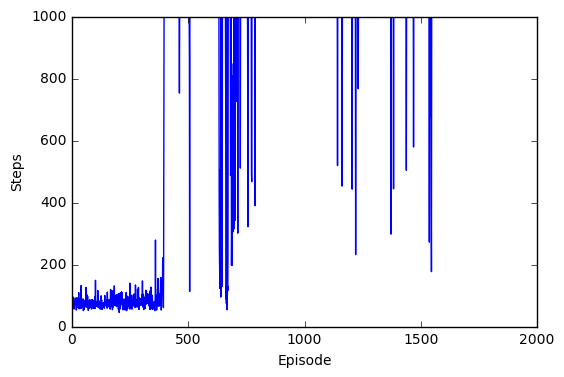

In [20]:
plt.plot(steps_per_episode)
plt.xlabel('Episode')
plt.ylabel('Steps')

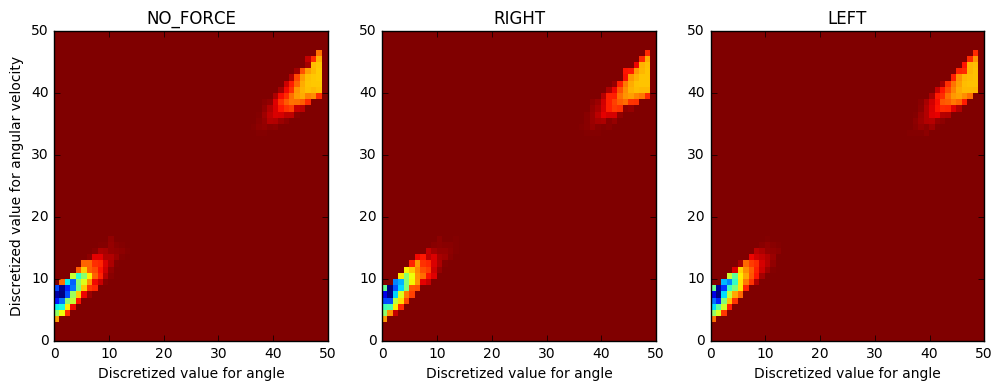

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes):
    ax.pcolor(Q[:, i].reshape(50, 50))
    ax.set_xlabel('Discretized value for angle')
    if i == 0:
        ax.set_ylabel('Discretized value for angular velocity')
    ax.set_title(env.actions.keys()[i])

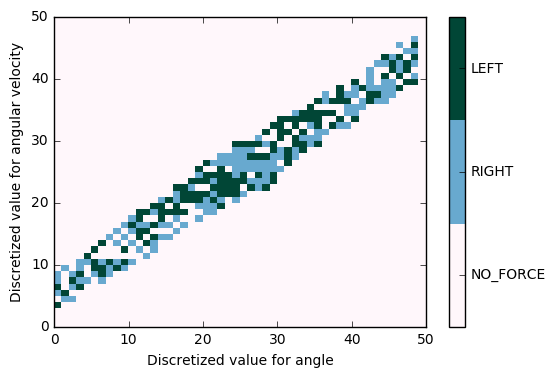

In [22]:
cmap=plt.cm.PuBuGn
import matplotlib
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

plt.pcolor(Q.argmax(axis=1).reshape(50, 50), cmap=cmap, norm=norm)
plt.xlabel('Discretized value for angle')
plt.ylabel('Discretized value for angular velocity')

plt.colorbar(ticks=[0, 1, 2]).set_ticklabels(env.actions.keys())